In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import os.path

import plot
import calculate

In [2]:
authorPublicationData = pd.read_csv('data/author_publications_1970_2016_asiansAsNone.txt')
# To speed up the implementation, consider a small dataset

authorPublicationData.head()

,author,year,pub_id
0,kim l. blackwell,2014,55503da645ce0a409eb273e8
1,nima mesgarani,2014,55503da645ce0a409eb273e9
2,james j. abbas,2014,55503da645ce0a409eb273ea
3,eberhart zrenner,2014,55503da645ce0a409eb273ec
4,jonathan rubin,2014,55503da645ce0a409eb273e0


### 1.7 million authors and 3 million publications over 47 years (1970 to 2016) are available from the data

In [3]:
#Unique values
print('Authors# - ',authorPublicationData['author'].nunique())
print('Year# - ',authorPublicationData['year'].nunique())
print('Publications# - ',authorPublicationData['pub_id'].nunique())

# # how many unique publications per author? In how many unique years was an author active
# # this takes some time, but we can save result to file
# file = "./data/author_unique_pubs_and_years2.csv"
# from pathlib import Path

# if not os.path.exists(file):
#     print("File does not exists - creating !!!")
#     table = authorPublicationsData.groupby("author").aggregate({'year': pd.Series.nunique, 'pub_id': pd.Series.nunique})
#     table.head()
#     table.to_csv(file, header=True, encoding="utf-8")
# else:
#     table = pd.read_csv(file, encoding="utf-8", header=0)

# table.head(20)

('Authors# - ', 1708185)
('Year# - ', 47)
('Publications# - ', 3085544)


In [4]:
#Publication ID details are irrelevant for analysis - Keep the count information for each author

authorPublicationData = authorPublicationData.groupby(['year','author']).count().reset_index()
authorPublicationData.rename(columns={'pub_id':'num_pub'}, inplace=True)

In [5]:
#get the year list - as it helps to enumerate and find gini co-efficient for each year (irrespective of the dataset)
years = np.sort(authorPublicationData['year'].unique())
print(years)

[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016]


### Compute Start, End year, Publication count and Career length for each author

In [6]:
#Group by author and find their start and end of their career by looking at their publish details
# and also count the no. of publications that he/she has
groupByAuthor = authorPublicationData.groupby(['author'])
# find the minimum and maximum year of publications and its count for each author
groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['num_pub'].sum()

In [7]:
# merge all the information into one and save it to a file
authorScientificYearStart = groupByAuthorMinYearData.reset_index()
authorScientificYearStart.rename(inplace=True, columns={'author':'author','year':'start_year'})
authorScientificYearEnd = groupByAuthorMaxYearData.reset_index()
authorScientificYearEnd.rename(inplace=True, columns={'author':'author','year':'end_year'})
authorPublishCount = groupByAuthorCountPublicationsData.reset_index()
authorPublishCount.rename(inplace=True, columns={'author':'author','num_pub':'total_num_pub'})

authorScientificYearStartEnd = authorScientificYearStart.merge(authorScientificYearEnd,on='author')
authorScientificYearStartEnd_publish_count = authorScientificYearStartEnd.merge(authorPublishCount,on='author')

print('authorScientificYearStartEnd_publish_count before filtering - ',authorScientificYearStartEnd_publish_count.shape[0])
authorScientificYearStartEnd_publish_count = authorScientificYearStartEnd_publish_count[authorScientificYearStartEnd_publish_count["start_year"] >= 1970]
print('authorScientificYearStartEnd_publish_count after filtering - ',authorScientificYearStartEnd_publish_count.shape[0])

print("authorScientificYearStartEnd_publish_count with duplicates: %s", authorScientificYearStartEnd_publish_count.shape[0])
authorScientificYearStartEnd_publish_count = authorScientificYearStartEnd_publish_count.drop_duplicates()
print("authorScientificYearStartEnd_publish_count with no duplicates: %s", authorScientificYearStartEnd_publish_count.shape[0])

print("authorScientificYearStartEnd_publish_count with null values: %s", authorScientificYearStartEnd_publish_count.shape[0])
authorScientificYearStartEnd_publish_count = authorScientificYearStartEnd_publish_count.dropna(how='any')
print("authorScientificYearStartEnd_publish_count without null values: %s", authorScientificYearStartEnd_publish_count.shape[0])

print(authorScientificYearStartEnd_publish_count.head())

('authorScientificYearStartEnd_publish_count before filtering - ', 1708185)
('authorScientificYearStartEnd_publish_count after filtering - ', 1708185)
('authorScientificYearStartEnd_publish_count with duplicates: %s', 1708185)
('authorScientificYearStartEnd_publish_count with no duplicates: %s', 1708185)
('authorScientificYearStartEnd_publish_count with null values: %s', 1708185)
('authorScientificYearStartEnd_publish_count without null values: %s', 1708185)
                  author  start_year  end_year  total_num_pub
0       'maseka lesaoana        2001      2015              2
1  (max) zong-ming cheng        2009      2011              2
2       (zhou) bryan bai        2011      2012              2
3                  a lun        2010      2010              1
4             a min tjoa        1979      2015            193


/home/kandy/python-virtual-env/cum-adv/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


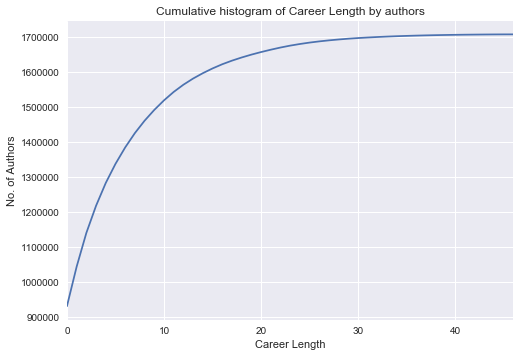

In [8]:
authorScientificYearStartEnd_publish_count["career_length"] = authorScientificYearStartEnd_publish_count['end_year'] - \
                                                              authorScientificYearStartEnd_publish_count['start_year']   
#authorScientificYearStartEnd_publish_count["career_length"].plot.hist(bins=40)
careerLengthDist = authorScientificYearStartEnd_publish_count.groupby(["career_length"])['author'].count()
temp = careerLengthDist.cumsum()  
ax = temp.plot(grid=True, title='Cumulative histogram of Career Length by authors')
ax.set_xlabel('Career Length')
ax.set_ylabel('No. of Authors')

plt.show()

### Save the data for futher usage

In [9]:
CAREER_LENGTH_LIST = [0,5,10,15,20,25]

for CAREER_LENGTH in CAREER_LENGTH_LIST:
    credible_authors = authorScientificYearStartEnd_publish_count[authorScientificYearStartEnd_publish_count['career_length'] >= CAREER_LENGTH]
    credible_authors.to_csv('data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv',
                        index=False, encoding='utf-8')
    

# fig = plt.figure(figsize=(20,10))
# ax1 = fig.add_subplot(1,1,1)
# authorPublicationData.boxplot(ax=ax1,column='num_pub',by='year', showfliers=False, return_type='axes')
# plt.show()

#### There are about 1.7 milliion authors.  More than 900K (nearly half of all authors) have ended their career on the same year they started. Nearly 1.5 million authors have career length less than 10 years. 

#### In order to prove cumulative advantage exists - analysis should be done among scientists who perform to some extent atleast, which is measured by their career length. The inclusion of many non-performing scientists will impact the GINI coefficient anyways which is used as a measure of inequality in performances

#### An appropriate career length should be chosen which

##### 1) removes many non-performing scientists 
##### 2) allows enough size in each cohort group 
##### 3) gives considerable years to compare their performance

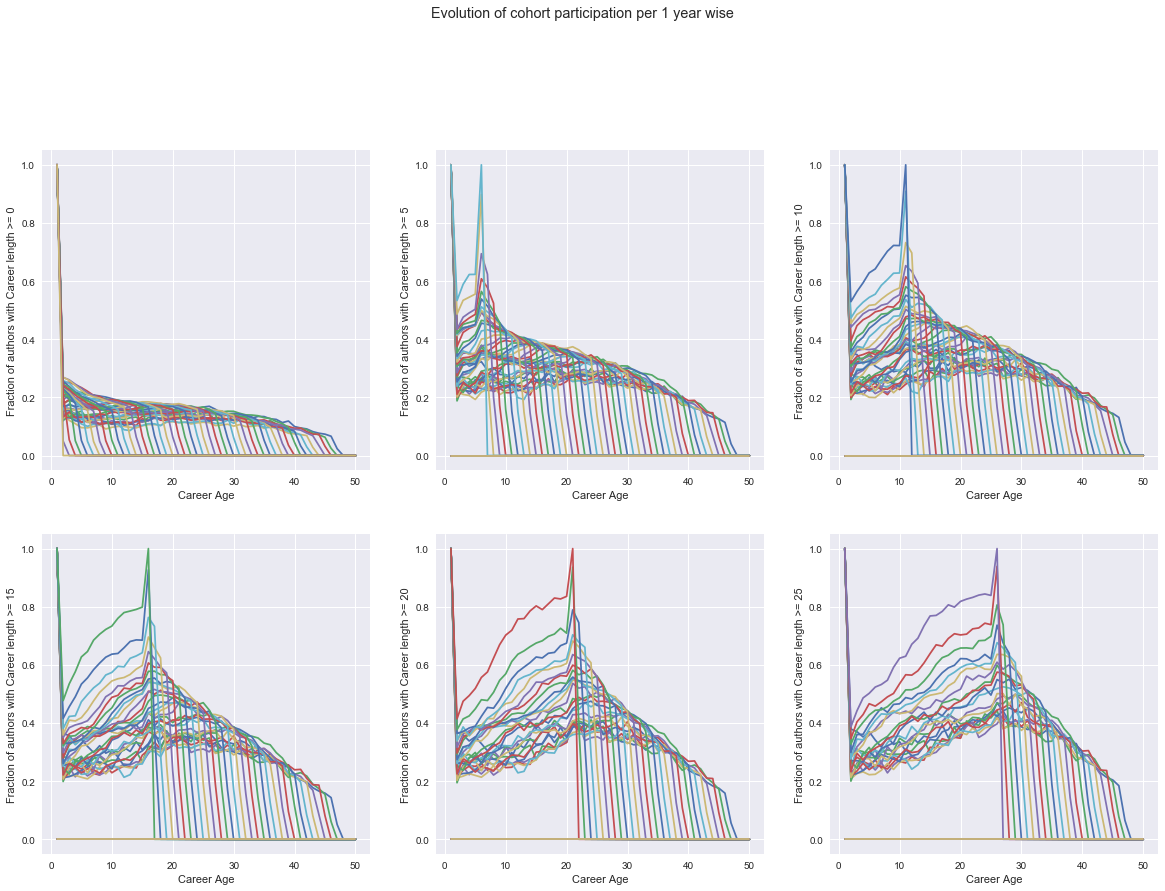

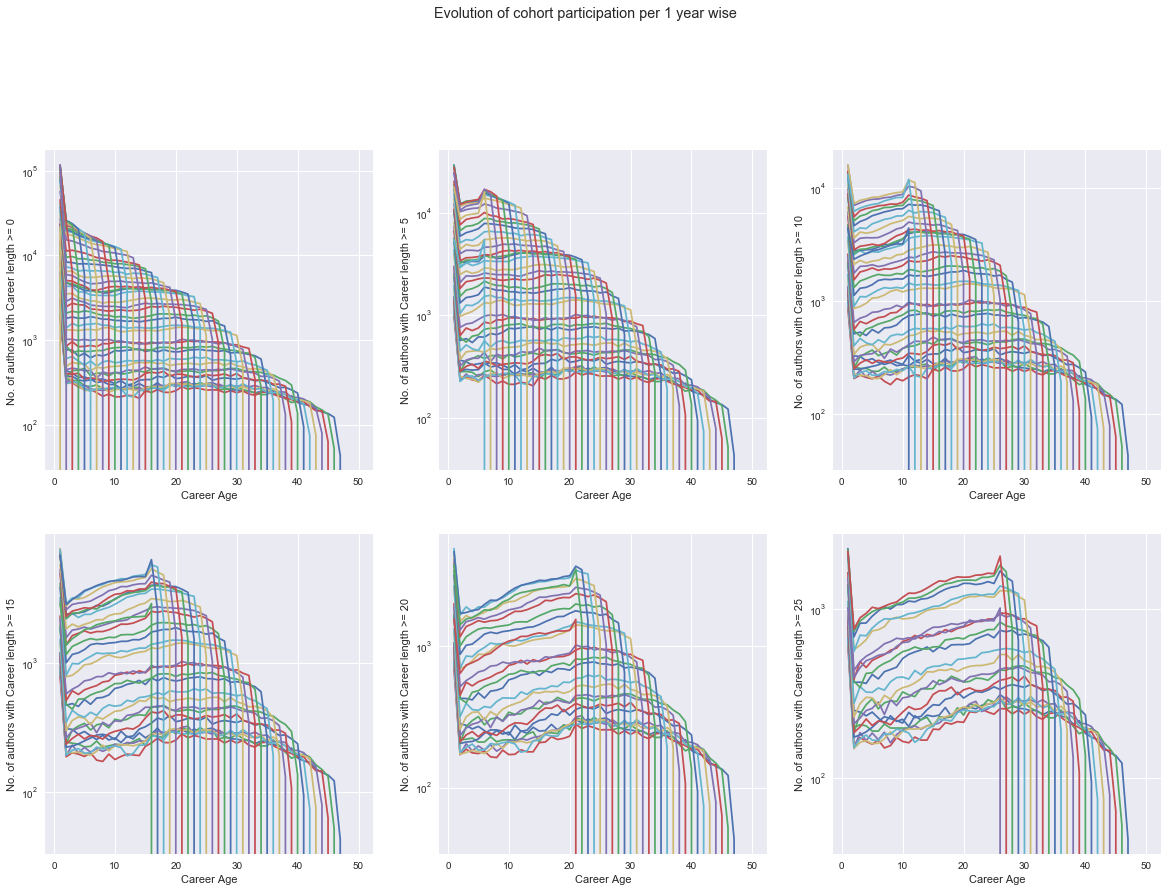

In [10]:
#Try with different career length and see (what fraction of/how many of researchers) in each cohort is available over their career span
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
#CAREER_LENGTH_LIST = [0]

plot.plot_cohort_participation_year_wise_for(authorScientificYearStartEnd_publish_count, authorPublicationData,CAREER_LENGTH_LIST)

Notes or Analysis:
* Our baseline for this analysis - it is mandatory to have atleast 100 authors in each cohort and 10 cohorts atleast should be analysed for atleast 10 years
* Good news is that - in all the above constraints we have 100 authors per each cohort. (20% of cohort size is maintained)

20-30 cohorts are good enough, considering that, career length -15 and 20 is looking promising

In [11]:
#just for debugging
reload(plot)
reload(calculate)

<module 'calculate' from 'calculate.pyc'>

### Group the authors by contribution in 2 years

In [12]:
groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(5))
# GROUPING BY 2 years
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(5))

        year            author  num_pub
88431   1985  donatella sciuto        1
117504  1987  donatella sciuto        1
135512  1988  donatella sciuto        2
156919  1989  donatella sciuto        1
181582  1990  donatella sciuto        2
('data with duplicates: %s', 4704589)
('data without duplicates: %s', 3704723)
('data with null values: %s', 3704723)
('data without null values: %s', 3704723)
        year            author  num_pub  cum_num_pub
64680   1984  donatella sciuto        1            1
86995   1986  donatella sciuto        1            2
140910  1988  donatella sciuto        3            5
187744  1990  donatella sciuto        6           11
250364  1992  donatella sciuto       13           24


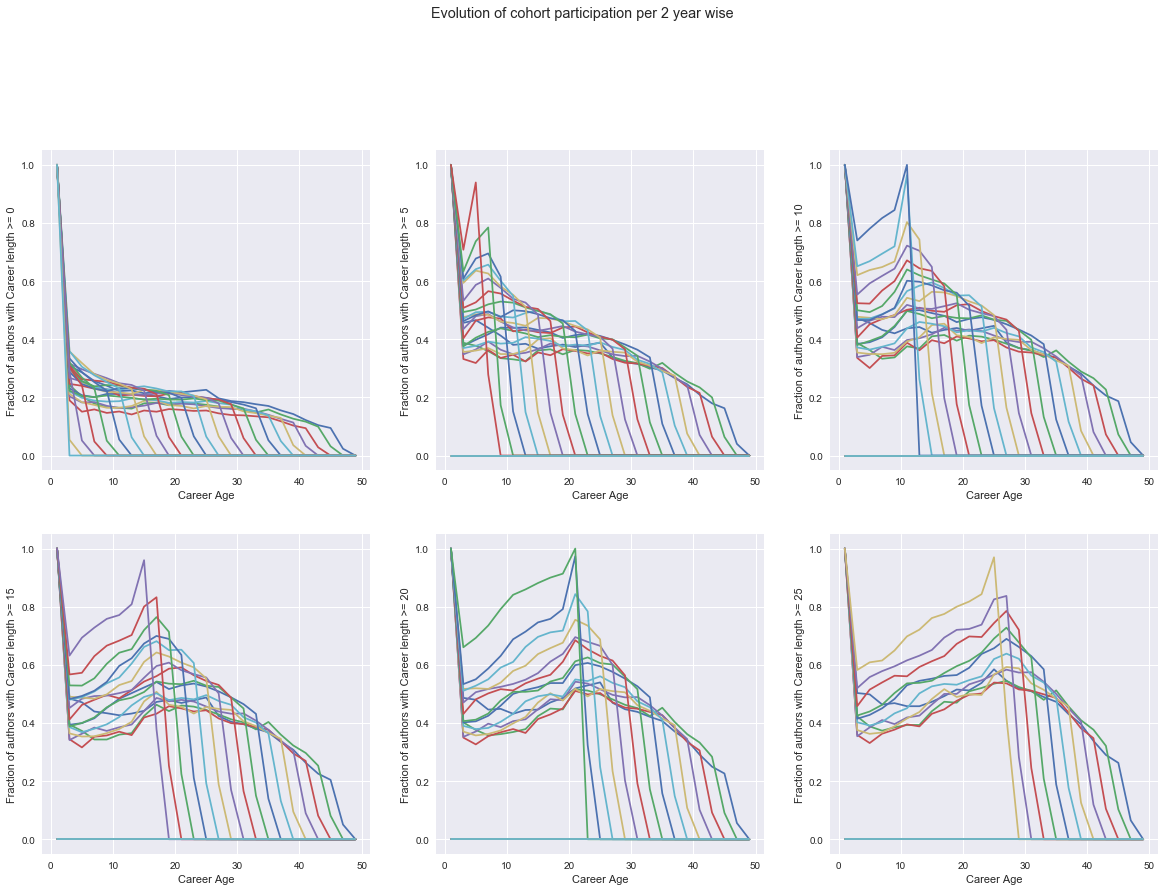

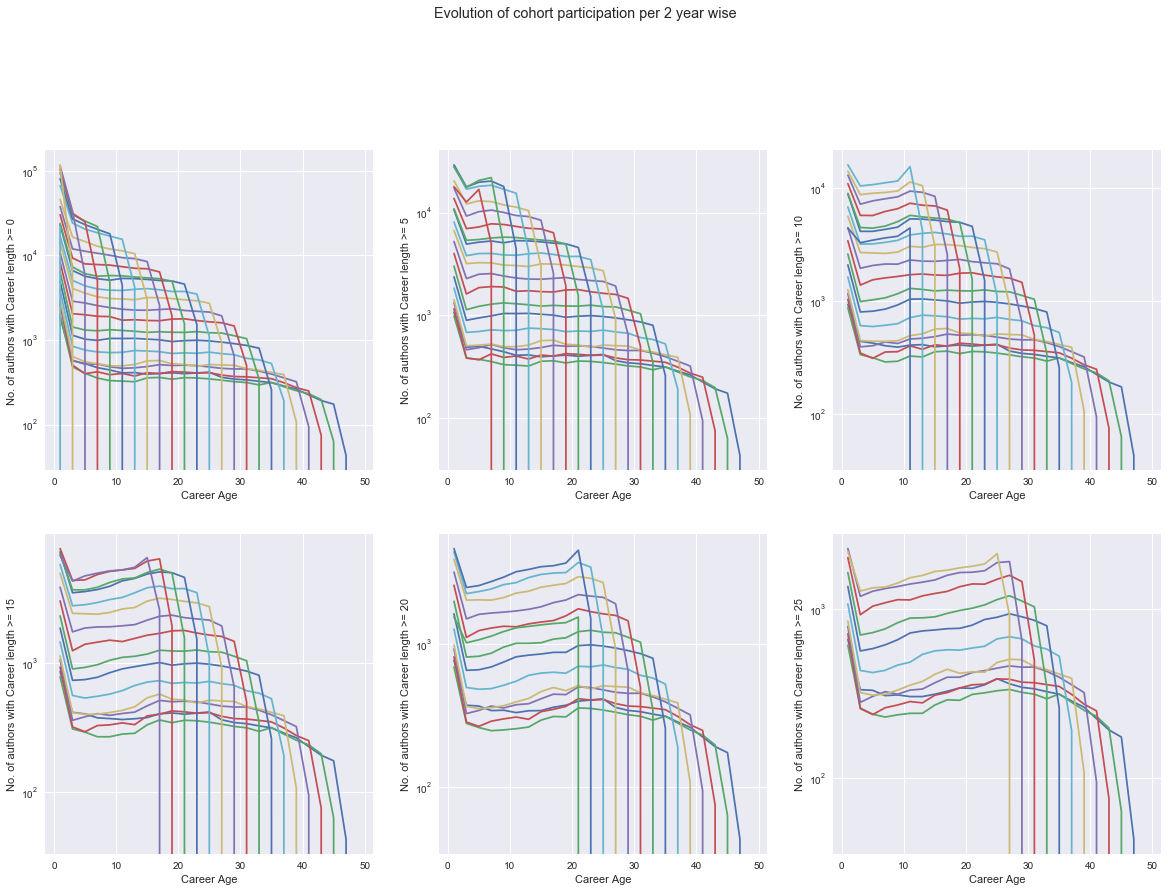

In [13]:
#Try with different career length and see (what fraction of/how many of researchers) in each cohort is available over their career span
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
#CAREER_LENGTH_LIST = [0]
plot.plot_cohort_participation_year_wise_for(authorScientificYearStartEnd_publish_count, groupByYearData,CAREER_LENGTH_LIST)

### Group the authors by contribution in 3 years

In [14]:
groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(5))
# GROUPING BY 2 years
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(5))

        year            author  num_pub
88431   1985  donatella sciuto        1
117504  1987  donatella sciuto        1
135512  1988  donatella sciuto        2
156919  1989  donatella sciuto        1
181582  1990  donatella sciuto        2
('data with duplicates: %s', 4704589)
('data without duplicates: %s', 3260031)
('data with null values: %s', 3260031)
('data without null values: %s', 3260031)
        year            author  num_pub  cum_num_pub
93609   1985  donatella sciuto        2            2
144353  1988  donatella sciuto        5            7
220263  1991  donatella sciuto       17           24
327723  1994  donatella sciuto       40           64
472913  1997  donatella sciuto       38          102


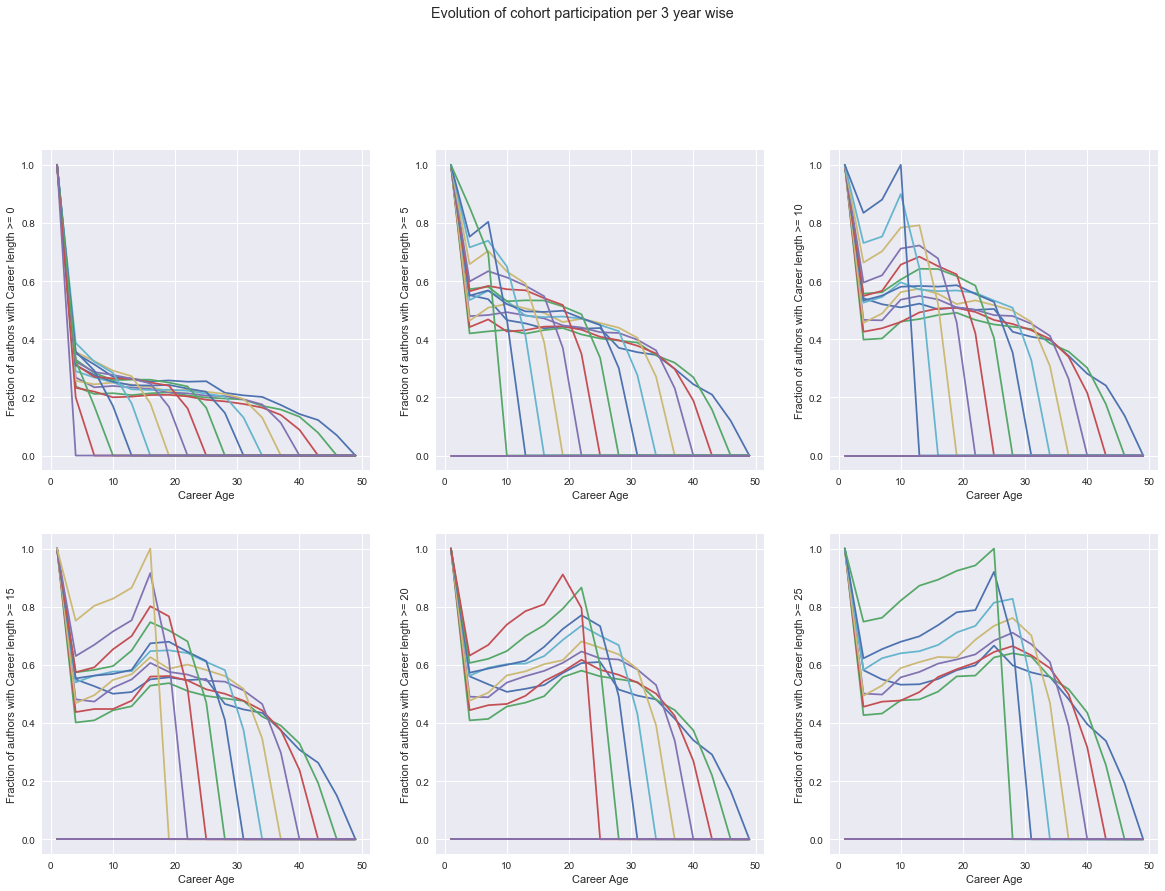

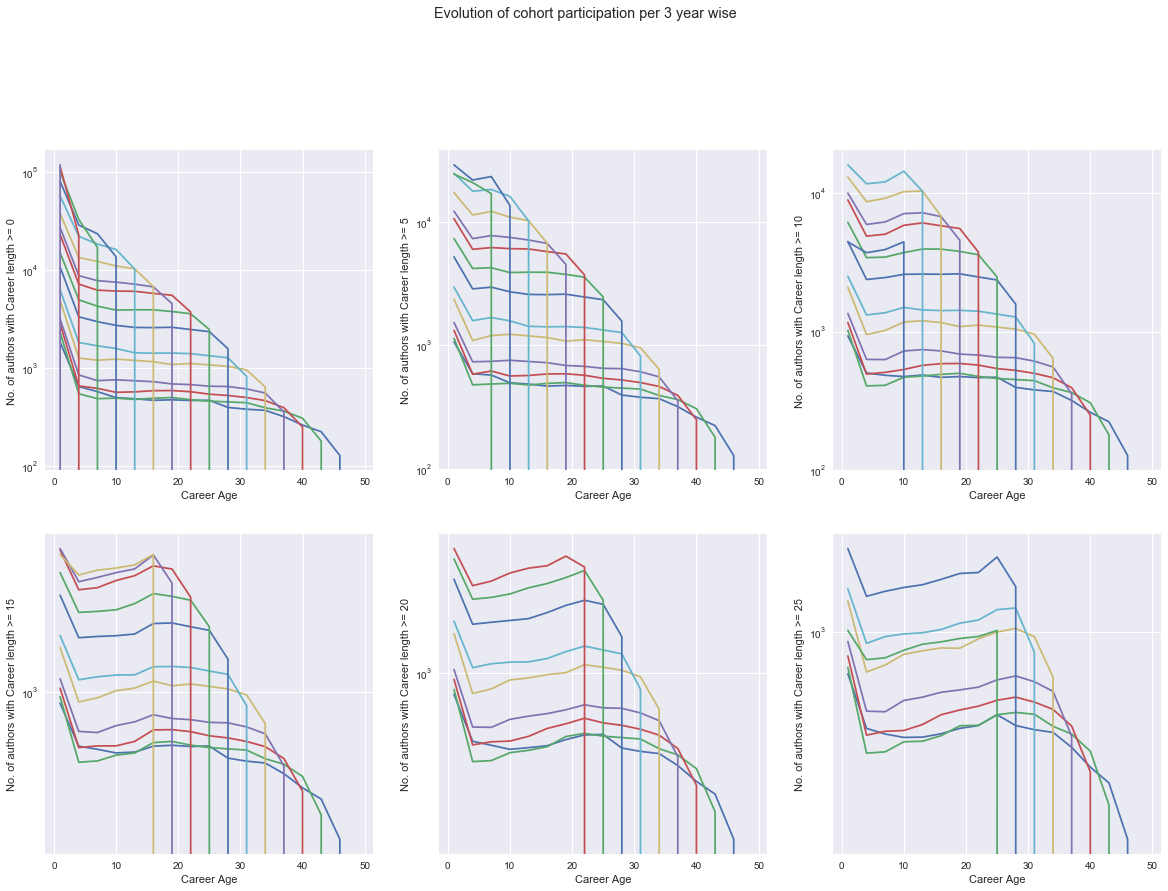

In [15]:
#Try with different career length and see (what fraction of/how many of researchers) in each cohort is available over their career span
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
#CAREER_LENGTH_LIST = [0]
plot.plot_cohort_participation_year_wise_for(authorScientificYearStartEnd_publish_count, groupByYearData,CAREER_LENGTH_LIST)

### END - the rest of the code can be avoided

### Filter Cohorts: remove authors who have less than N years of career 


In [9]:
# Make a list of career length 
step = 3
count = (max(years) - min(years)) / step
count = int(count)
career_length_list = range(count+1) 
career_length_list = [num*step for num in career_length_list]
print(career_length_list)

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45]


In [68]:
career_length_cohort = pd.DataFrame(index=years)
per_career_length_cohort = pd.DataFrame(index=years)

career_age_0 = authorScientificYearStartEnd_publish_count.groupby(['start_year'])['author'].count()
for career_length in range(0,(max(years) - min(years))):
    temp = authorScientificYearStartEnd_publish_count[authorScientificYearStartEnd_publish_count['career_length'] >= career_length]
    career_length_cohort[str(career_length)] = temp.groupby(['start_year'])['author'].count()
    per_career_length_cohort[str(career_length)] = career_length_cohort[str(career_length)] / career_age_0
    
career_length_cohort.replace(to_replace=np.NaN, value=0, inplace=True)
career_length_cohort.head()

per_career_length_cohort.replace(to_replace=np.NaN, value=0, inplace=True)
per_career_length_cohort.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
1970,1,0.661580,0.635422,0.613079,0.597275,0.582561,0.562943,0.548774,0.534060,0.519891,...,0.217439,0.203815,0.189646,0.172752,0.159673,0.144959,0.130245,0.115531,0.097003,0.069755
1971,1,0.578872,0.558317,0.540631,0.520076,0.503824,0.491874,0.479446,0.467495,0.457935,...,0.206979,0.191683,0.183078,0.173518,0.158700,0.135755,0.111855,0.092734,0.068834,0.024857
1972,1,0.582745,0.557518,0.532795,0.512614,0.496973,0.481837,0.469223,0.456609,0.446014,...,0.201312,0.185166,0.172553,0.154390,0.142785,0.118567,0.102926,0.080727,0.031786,0.000000
1973,1,0.576338,0.548499,0.525011,0.507612,0.495868,0.483254,0.472814,0.462810,0.453241,...,0.194867,0.176599,0.157895,0.142671,0.126142,0.105698,0.078295,0.034363,0.000000,0.000000
1974,1,0.534392,0.489796,0.465986,0.448602,0.436886,0.423280,0.411565,0.402494,0.395692,...,0.157974,0.143991,0.127362,0.113379,0.097128,0.074830,0.028345,0.000000,0.000000,0.000000


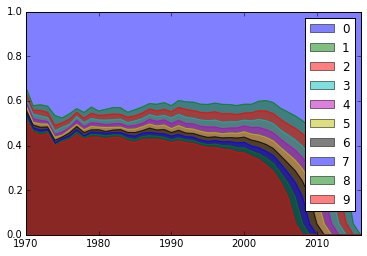

In [70]:
interested_career_lengths = [str(num) for num in range(0,10)]
per_career_length_cohort[interested_career_lengths].plot(kind='area', stacked=False)

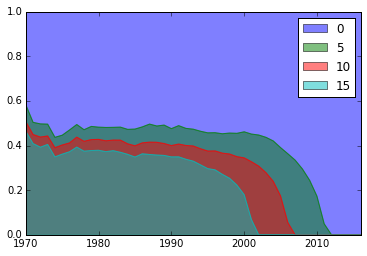

In [71]:
interested_career_lengths = [str(num) for num in range(0,20,5)]
per_career_length_cohort[interested_career_lengths].plot(kind='area', stacked=False)

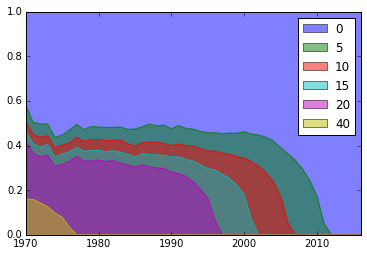

In [50]:
per_df[['0','5','10','15','20','40']].plot(kind='area', stacked=False)

In [57]:
new_df['0'].values

array([  1835,   2092,   1982,   2299,   2646,   2465,   2819,   3023,
         3005,   3165,   3813,   4069,   4908,   5259,   6376,   6273,
         8267,   8838,  10720,  11554,  14037,  15028,  16943,  20800,
        22956,  22949,  23742,  27081,  30111,  33623,  37590,  42074,
        45634,  56919,  66725,  75357,  80191,  86222,  94403, 100290,
       103104, 112148, 113598, 114504, 116971, 118000,  21777])

In [56]:
percentage_df = new_df / new_df['0'].values
percentage_df.head()

ValueError: Wrong number of items passed 47, placement implies 10

In [35]:
career_atleast_5_years = cohortGroup[cohortGroup['career_length'] > 5]
career_atleast_5_years.head()

KeyError: 'Column not found: True'

count      32.00000
mean     3465.25000
std      2522.70257
min       778.00000
25%      1172.50000
50%      2582.00000
75%      5990.00000
max      7624.00000
Name: num_author_filtered, dtype: float64
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001]


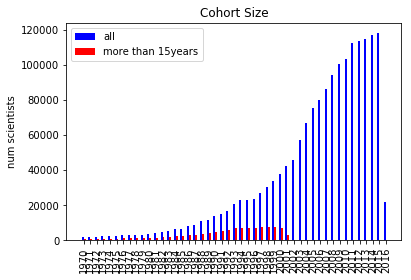

In [28]:
N = 15

authorScientificYearStartEnd_publish_count["career_length"] = authorScientificYearStartEnd_publish_count['end_year'] - authorScientificYearStartEnd_publish_count['start_year']   
#print(authorScientificYearStartEnd_publish_count.head())

credible_authors = authorScientificYearStartEnd_publish_count[authorScientificYearStartEnd_publish_count.career_length >= N ]
#print(credible_authors.head())

credible_cohort = credible_authors.groupby("start_year").count()
credible_cohort.rename(columns = {'author':'num_author_filtered'}, inplace = True)
#print(credible_cohort.head())

# how many people remain in each cohort after filtering
print(credible_cohort["num_author_filtered"].describe())

#looks like we only observe 10 or more career years for people who started later --> DBPL coverage became better in later years
print(credible_cohort.reset_index()["start_year"].unique())

# visualize changes after filtering!

num_newbies.rename(columns = {'author':'num_author'}, inplace = True)
cohort_size = pd.DataFrame(num_newbies["num_author"]).join(credible_cohort["num_author_filtered"])
#print(cohort_size)


fig, ax = plt.subplots()
width = 0.3       # the width of the bars
Y = len(cohort_size.reset_index()["start_year"])
ind = np.arange(Y)

rects1 = ax.bar(ind, cohort_size["num_author"], width, color='b')
rects2 = ax.bar(ind+ width, cohort_size["num_author_filtered"], width, color='r')
ax.set_ylabel('num scientists')
ax.set_title('Cohort Size')
ax.set_xticks(ind + width / 2)

ax.set_xticklabels(cohort_size.reset_index()["start_year"], rotation=90)

ax.legend((rects1[0], rects2[0]), ('all', 'more than '+str(N)+'years'))


In [29]:
print(ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


In [30]:
credible_authors.to_csv('data/authors-scientific-atleast-'+str(N)+'-year.csv',
                        index=False, encoding='utf-8')

In [17]:
print(authorPublicationsData.head())

credibleAuthorPublicationsData = authorPublicationsData[authorPublicationsData['author'].isin(credible_authors['author'])]
credibleAuthorPublicationsData.reset_index(inplace=True)

#Crosschecking whether the filtering worked or not
print('Authors# - ',credibleAuthorPublicationsData['author'].nunique())
print('Year# - ',credibleAuthorPublicationsData['year'].nunique())
print('Publications# - ',credibleAuthorPublicationsData['pub_id'].nunique())

             author  year                    pub_id
0  kim l. blackwell  2014  55503da645ce0a409eb273e8
1    nima mesgarani  2014  55503da645ce0a409eb273e9
2    james j. abbas  2014  55503da645ce0a409eb273ea
3  eberhart zrenner  2014  55503da645ce0a409eb273ec
4    jonathan rubin  2014  55503da645ce0a409eb273e0
Authors# -  110888
Year# -  47
Publications# -  2218542


In [126]:
#todo: remove this part to avoid redundancy and copied code

### For scientists-10-years-10-papers
#### We examine when authors start their publications and how does their distribution looks like
#### At the same time, when does their scientific career ends and how does the distribution looks like

In [127]:
#Group by author
groupByAuthor = credibleAuthorPublicationsData.groupby(['author'])
# find the minimum and maximum year of publications and its count for each author
groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['pub_id'].count()

### More no. of new scientfic researchers are involved as the year progresses
#### At year 2005 - fewer new scientists have published ( as of now ignoring it - could be a problem in code)
#### No. of cohort groups is 36
#### Minimum cohort size is 433 and maximum is 8465
#### 75% of 36 groups are over 736 in group size

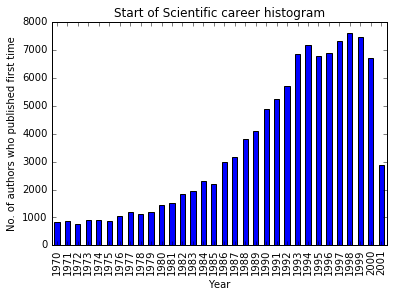

count      32.000000
mean     3452.125000
std      2514.386846
min       770.000000
25%      1167.250000
50%      2579.000000
75%      5968.000000
max      7596.000000
Name: year, dtype: float64

In [128]:
scientificYearStartHistogram = groupByAuthorMinYearData.value_counts(sort=False)
ax = scientificYearStartHistogram.sort_index().plot(kind='bar', title='Start of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published first time")

plt.show()

scientificYearStartHistogram.describe()

In [129]:
#Manually checked to ensure they are right
scientificYearStartHistogram.sort_index()

1970     841
1971     859
1972     770
1973     924
1974     923
1975     883
1976    1041
1977    1181
1978    1126
1979    1190
1980    1431
1981    1503
1982    1840
1983    1938
1984    2289
1985    2182
1986    2979
1987    3161
1988    3820
1989    4101
1990    4893
1991    5234
1992    5718
1993    6845
1994    7166
1995    6775
1996    6903
1997    7310
1998    7596
1999    7459
2000    6718
2001    2869
Name: year, dtype: int64

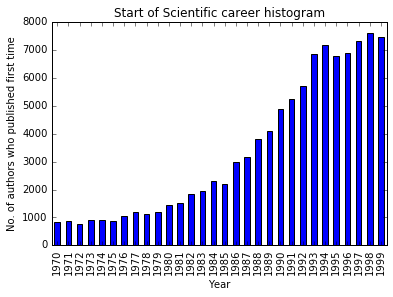

count      30.000000
mean     3362.700000
std      2523.957609
min       770.000000
25%      1139.750000
50%      2235.500000
75%      5597.000000
max      7596.000000
Name: year, dtype: float64

In [130]:
scientificYearStartHistogram = groupByAuthorMinYearData.value_counts(sort=False)
ax = scientificYearStartHistogram[scientificYearStartHistogram.index < 2000].sort_index().plot(kind='bar', title='Start of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published first time")

plt.show()

scientificYearStartHistogram[scientificYearStartHistogram.index < 2000].describe()

### Culmination of research increases as  year progresses - Correlates with the increase of Start of Scientific career
#### At year 2016, there is a dip - need to analyse it - we shall ignore for this moment

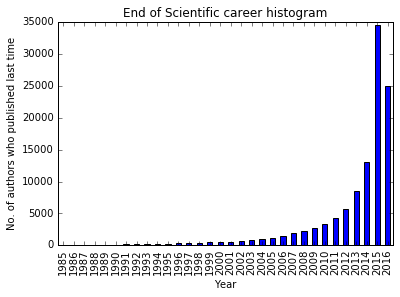

count       32.000000
mean      3452.125000
std       7539.500633
min         15.000000
25%        199.500000
50%        558.500000
75%       2328.750000
max      34481.000000
Name: year, dtype: float64

In [131]:
scientificYearEndHistogram = groupByAuthorMaxYearData.value_counts(sort=False)
ax = scientificYearEndHistogram.sort_index().plot(kind='bar', 
                                                  title='End of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published last time")
#ax.set_ylim([0,3000])
plt.show()

scientificYearEndHistogram.describe()

In [132]:
scientificYearEndHistogram.sort_index()

1985       15
1986       35
1987       41
1988       77
1989       91
1990      120
1991      142
1992      192
1993      202
1994      237
1995      251
1996      283
1997      348
1998      381
1999      468
2000      526
2001      591
2002      703
2003      829
2004      960
2005     1209
2006     1490
2007     1895
2008     2178
2009     2781
2010     3402
2011     4273
2012     5713
2013     8481
2014    13032
2015    34481
2016    25041
Name: year, dtype: int64

#### Some other analysis that could be done  are
1) We find the best/better cohort group(s) that can be compared. As of now, if we consider atleast 15 years of research can be used for comparison then we have 32 cohort groups (1970 to 2001)
Best cohort group - similar characteristics (there might be many reasons for one to end his/her scientific career)
Consider people who start and at the same time end their career as well ???
Also Consider their growth (their peak time and the trend) ???

2) Increase the cohort group size - Can group the authors by years

3) Drop out rates are high - this is why we insist 10/20 year 10/20 paper constraint

### For scientists-20-years-20-papers
#### We examine when authors start their publications and how does their distribution looks like
#### At the same time, when does their scientific career ends and how does the distribution looks like

In [133]:
credibleAuthorPublicationsData = authorPublicationsData[authorPublicationsData['author'].isin(credible_authors_20['author'])]
credibleAuthorPublicationsData.reset_index(inplace=True)

#Crosschecking whether the filtering worked or not
print('Authors# - ',credibleAuthorPublicationsData['author'].nunique())
print('Year# - ',credibleAuthorPublicationsData['year'].nunique())
print('Publications# - ',credibleAuthorPublicationsData['pub_id'].nunique())

NameError: name 'credible_authors_20' is not defined

In [ ]:
#Group by author
groupByAuthor = credibleAuthorPublicationsData.groupby(['author'])
# find the minimum and maximum year of publications and its count for each author
groupByAuthorMinYearData = groupByAuthor['year'].min()
groupByAuthorMaxYearData = groupByAuthor['year'].max()
groupByAuthorCountPublicationsData = groupByAuthor['pub_id'].count()

In [ ]:
scientificYearStartHistogram = groupByAuthorMinYearData.value_counts(sort=False)
ax = scientificYearStartHistogram.sort_index().plot(kind='bar', title='Start of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published first time")
plt.show()

scientificYearStartHistogram.describe()

In [ ]:
scientificYearEndHistogram = groupByAuthorMaxYearData.value_counts(sort=False)
ax = scientificYearEndHistogram.sort_index().plot(kind='bar', title='End of Scientific career histogram')
ax.set_xlabel("Year")
ax.set_ylabel("No. of authors who published last time")
plt.show()

scientificYearEndHistogram.describe()

In [ ]:
end_time = timeit.default_timer()
print('End Time (in sec) - ',end_time)
print('Time taken (in sec) - ',end_time-start_time)

### Cohort Size group (whether individual years are good enough or clubs of few years are required)

* A cohort is a set of researchers that started their career in the same year. We use the first publication of a research as proxy for his/her career start. Since we want to follow researchers over time, we only include researchers that were active over at least 10 years (i.e., they published at least 2 papers, their first one and another one 10 years later)
* What is the size of each cohort?
* Record for those people how many papers they publish in each year, how many citations they have received, their h-index


#### First and foremost - let us look at the performance of researchers
#### We need to remove the dropouts based on following condition
##### researchers whose career span is less than 10 years 
##### and has published less than 10 papers (necessary ? - as of now keeping it)